# Forums

In [98]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import utils
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

from datetime import datetime

In [99]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [100]:
def clean_tokenize_lemmatize(comment):
    '''
    Removes HTML tags and stopwords.
    Converts words to its base using lemmatization.
    
    
    Args:
        comment (str) : Content of the author's post in Wall Street Market.
        
    Return:
        lem_tokens (arr) : The cleaned, tokenized and lemmetized version of comment.
        
    '''
    
    text = BeautifulSoup(comment, 'html.parser').get_text()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9$!?.]', ' ', text)
    
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    
    wordnet_lemma = nltk.WordNetLemmatizer()
    lem_tokens = [wordnet_lemma.lemmatize(t) for t in tokens]
    
    return lem_tokens

def fix_postdate_col(dt):
    '''
    The last 2 days have errors in the dates.
    This function resolves the errors.
    
    Args:
        dt (str) : date and time
    Returns:
        dt_revised (datetime) : date and time
    
    '''
    dt_split = dt.split(' ')
    date = dt_split[0]
    time = dt_split[1]
    
    if date == 'Yesterday':
        date = '2018-11-13'
    
    elif date == 'Today':
        date = '2018-11-14'
    
    dt_merged = date + ' ' + time
    dt_revised = datetime.strptime(dt_merged, '%Y-%m-%d %H:%M:%S')
    
    return dt_revised

# Does it matter?
def fix_author_join_date_col(join_date, author_membership, post_date):
    '''
    If a date is not in the value, function develops an assumption.
    
    Args:
        join_date (str) : Value for which the author is assumed to have joined.
        author_memberhsip (str) : Author's Wall Street membership level.
        post_date (datetime) : Date and time the author posted the corresponding comment.
        mode_date (str) : Most common date in the relavant data series.
        
    Returns:
        join_date_revised (datetime) : date 
    '''
    
    try:
        join_date_revised = datetime.strptime(join_date, '%Y-%m-%d')

    except:
        if author_membership == 'New member':
            join_date_revised = post_date.date()
        else:
            join_date_revised = np.nan
    
    return join_date_revised
    

# Wall Street 
## Data Processing and EDA

In [101]:
wallstreet = pd.read_csv('data/wallstreet.csv')

In [102]:
wallstreet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45372 entries, 0 to 45371
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   postID                45372 non-null  int64 
 1   threadID              45372 non-null  int64 
 2   threadTitle           45370 non-null  object
 3   URL                   45372 non-null  object
 4   subforum              45372 non-null  object
 5   authorName            45372 non-null  object
 6   postAuthorMembership  45372 non-null  object
 7   postAuthorJoinDate    45372 non-null  object
 8   authorReputation      45372 non-null  int64 
 9   postDate              45372 non-null  object
 10  postSequence          45372 non-null  int64 
 11  likes                 45372 non-null  int64 
 12  flatContent           45372 non-null  object
 13  contentWithHTMLTag    45372 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.8+ MB


In [103]:
total_num_posts_wall = wallstreet.shape[0] 
print('# of Postings: ', total_num_posts_wall)
print('# of Unique Threads : ', len(wallstreet['threadID'].unique()))
print('# of Unique Subforums : ', len(wallstreet['subforum'].unique()))
print('# of Unique Authors : ', len(wallstreet['authorName'].unique()))
print('# of Membership Types : ', len(wallstreet['postAuthorMembership'].unique()))

# of Postings:  45372
# of Unique Threads :  8755
# of Unique Subforums :  40
# of Unique Authors :  5533
# of Membership Types :  8


In [104]:
wall_authors = pd.DataFrame(wallstreet['authorName'].value_counts()).reset_index()
wall_authors.columns = ['author','num_postings']
wall_authors['prcnt_total_posts'] = wall_authors['num_postings'] / total_num_posts_wall
wall_authors.head(10)

,author,num_postings,prcnt_total_posts
0,med3l1n,4889,0.107754
1,6LACK,1500,0.033060
2,leaguemode,1146,0.025258
3,ExpectUS,1113,0.024531
4,PurityRing,1111,0.024486
5,BonesKoopa,476,0.010491
6,Icepapi,446,0.009830
7,code48k,379,0.008353
8,deusxmacina,354,0.007802
9,dabbingtimes,334,0.007361


In [105]:
wall_threads = pd.DataFrame(wallstreet['threadTitle'].value_counts()).reset_index()
wall_threads.columns = ['thread_topic','num_postings']
wall_threads['prcnt_total_posts'] = wall_threads['num_postings'] / total_num_posts_wall
wall_threads.head(10)

,thread_topic,num_postings,prcnt_total_posts
0,GozNym 2.0 Banking Bot (Page 1 of 3),75,0.001653
1,GozNym 2.0 Banking Bot (Page 2 of 3),75,0.001653
2,[Price & Version update] BTC ATM Malware,73,0.001609
3,GozNym 2.0 Banking Bot (Page 3 of 3),56,0.001234
4,Hello,52,0.001146
5,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
6,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
7,CASHAPP GUIDE,50,0.001102
8,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102
9,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102


In [106]:
wall_subforums = pd.DataFrame(wallstreet['subforum'].value_counts()).reset_index()
wall_subforums.columns = ['subforum','num_postings']
wall_subforums['prcnt_total_posts'] = wall_subforums['num_postings'] / total_num_posts_wall
wall_subforums.head(10)

,subforum,num_postings,prcnt_total_posts
0,Fraud,12277,0.270585
1,General Questions,5225,0.115159
2,Carding Stuff,3836,0.084546
3,Services,2973,0.065525
4,Cannabis,2431,0.053579
5,Introductions,2418,0.053293
6,Counterfeits,1727,0.038063
7,Stimulants,1537,0.033876
8,Announcements,1507,0.033214
9,Digital goods,1443,0.031804


In [107]:
wall_joindate = pd.DataFrame(wallstreet['postAuthorJoinDate'].value_counts()).reset_index()
wall_joindate.columns = ['join_date','count']
wall_joindate['prcnt_total_posts'] = wall_joindate['count'] / total_num_posts_wall
wall_joindate.head(10)

,join_date,count,prcnt_total_posts
0,Despacitoland,4889,0.107754
1,G,1500,0.033060
2,2017-11-06,1227,0.027043
3,2018-01-10,1146,0.025258
4,InterWebz,1113,0.024531
5,2017-07-27,524,0.011549
6,2018-03-03,498,0.010976
7,2017-11-09,427,0.009411
8,2018-05-06,415,0.009147
9,2017-10-17,403,0.008882


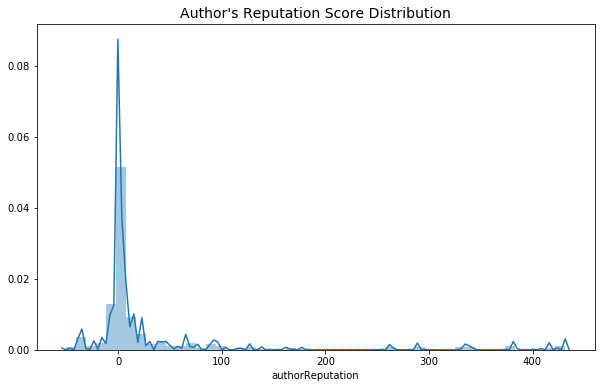

In [108]:
# Max value ~ 5,400.
constraint = 500
reputation = wallstreet[wallstreet['authorReputation'] < constraint]['authorReputation']
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(reputation)
ax.set_title("Author's Reputation Score Distribution", fontsize=14);

C:\Users\morga\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


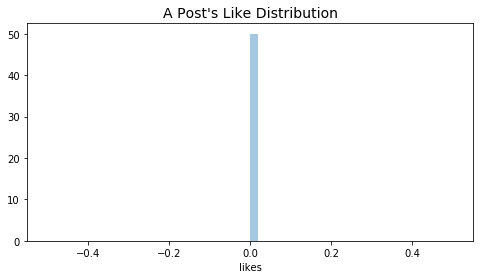

In [109]:
constraint = 100
likes = wallstreet[wallstreet['likes'] < constraint]['likes']
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.distplot(likes)
ax.set_title("A Post's Like Distribution", fontsize=14);

---
# Data Processing / Feature Engineering

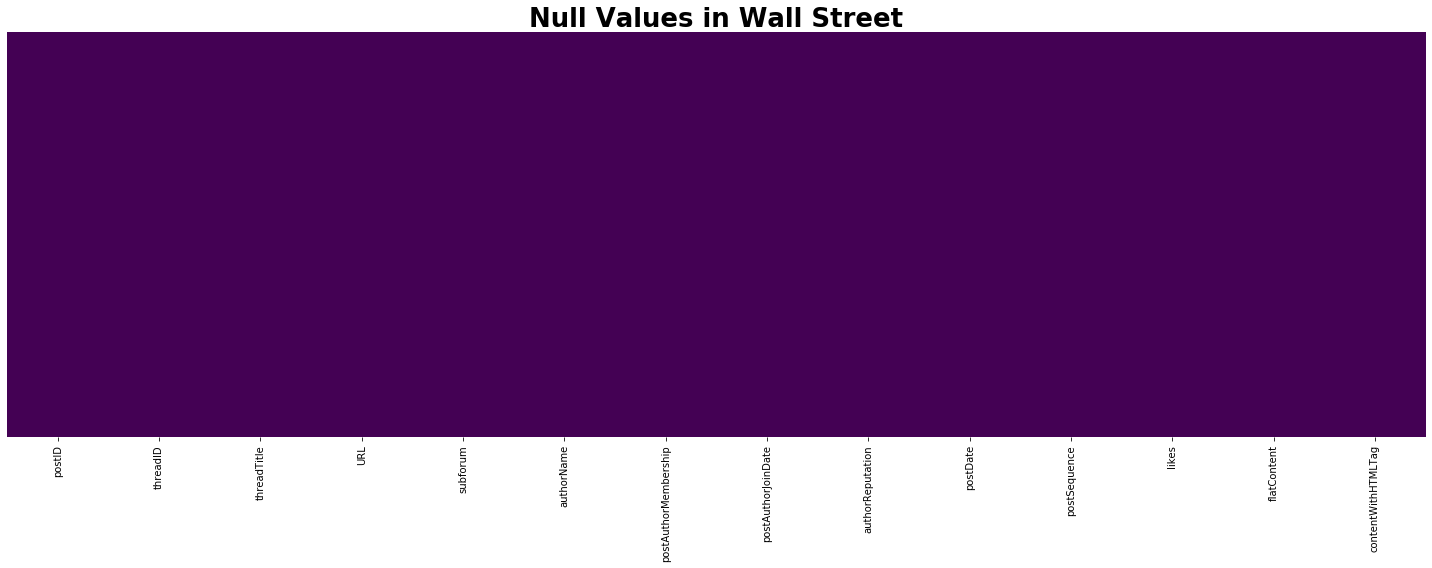

In [110]:
utils.plot_null_val_heatmap(wallstreet, 'Null Values in Wall Street', (20,8))

In [111]:
wallstreet_v2 = wallstreet.copy()

In [112]:
wallstreet_v2['post_date_dt'] = wallstreet_v2['postDate'].apply(lambda x: fix_postdate_col(x))
wallstreet_v2['author_join_date'] = wallstreet_v2.apply(lambda x: fix_author_join_date_col(x['postAuthorJoinDate'], x['postAuthorMembership'], x['post_date_dt']), axis=1)

In [113]:
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['post_date_dt'].dt.date - wallstreet_v2['author_join_date'].dt.date
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['num_days_member_when_posted'].dt.days

In [114]:
cols_to_drop = ['URL', 'likes', 'postDate', 'postAuthorJoinDate']
wallstreet_v2.drop(cols_to_drop, axis=1, inplace=True)

In [115]:
wallstreet_v2['lemmatized_tokens'] = wallstreet_v2['contentWithHTMLTag'].apply(lambda x: clean_tokenize_lemmatize(x))

---
# EDA w/ Engineered Features

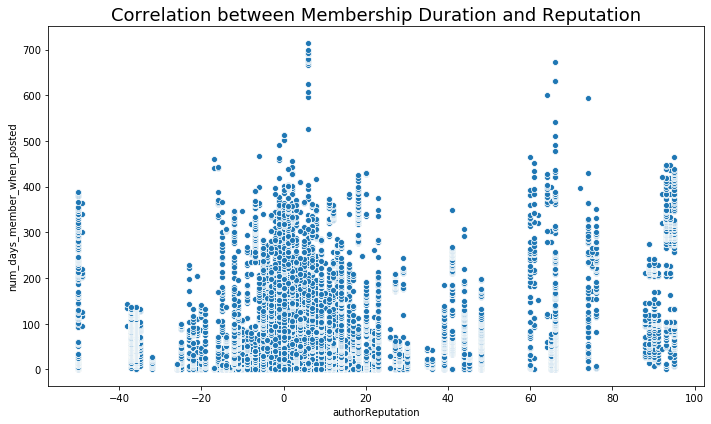

In [97]:
rep_limit = 500
excl_rep_outliers = wallstreet_v2[wallstreet_v2['authorReputation'] < rep_limit]

plt.figure(figsize=(10,6))

sns.scatterplot(y='num_days_member_when_posted', x='authorReputation', data=excl_rep_outliers)
plt.title('Correlation between Membership Duration and Reputation', fontsize=18)
plt.tight_layout();